<a href="https://colab.research.google.com/github/maxkotur/ml-stress-detection/blob/main/stress_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Imports
!pip install bert-for-tf2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 25 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30534 sha256=5546579c7025b337a234735566671b42de8a16afb9a563e749668706eff66a89
  Stored in directory: /root/.cache/pip/wheels/ab/a4/72/df07592cea3ae06b5e846f5e52262f8b16748e829ca354b7df
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19472 sha256=1af79fd33ef7f98958dd9aad0b567cefb2595167182b71a90a8c066da50e6ac0
  Stored in directory: /root/.cache/pip/wheels/c7/f3/85/b8cf1d8bfe55dc2ece0f1fcd4e91d6f8fc7b59ff3fd75329e1
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7911 sha256=9a864dc7baab184e9e80ae46a57dc5db3857fd41ab523c0bc905e07888dec3ce
  Stored in directory: /root/.cache/pip/wheels/ac/26/e9/df16869ccbd4abf517f1ff3be9a2c7ee5c5980fc87eea04fb1
Successfully built bert-for-tf2 params-flow py

In [10]:
import numpy as np
import pickle
import bert
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import tensorflow as tf
import tensorflow_hub as hub
import nltk
nltk.download('punkt')
from abc import ABC, abstractmethod # Abstract Base Classes for Python
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from gc import callbacks
from pandas import read_csv
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.layers import Embedding,Dense, Input, LSTM, Bidirectional, Dropout
from keras.models import Sequential, Model
from keras.optimizers import  Adam
from keras.callbacks import EarlyStopping
from keras.layers import LSTM
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


We start by loading our dataset for the ML model.

In [4]:
df=read_csv("sample_data/depression_dataset_reddit_cleaned.csv" )
df.head(20)

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1
5,i m year old turning soon in a few month i liv...,1
6,i live alone and despite me being prone to lon...,1
7,i m not looking for sympathy just simply to st...,1
8,i don t know how to communicate all of my thou...,1
9,mom i m sad it hurt in my heart the feeling fa...,1


Before we preprocess our dataset and prepare it for the training, let's have a look at the distribution of the labelled data.


In [5]:
df["is_depression"].value_counts()

0    3900
1    3831
Name: is_depression, dtype: int64

As we can see in the line above, our labels are almost 50% - 50%. Therefore, the dataset is not imbalanced. 

Next, we will take a look at the average word count of our input.

In [6]:
df_depression = df[df['is_depression'] == 1]
df_non_depression = df[df['is_depression'] == 0]

depression_avg_word_count = int(df_depression['clean_text'].str.split(" ").apply(len).mean())
nondepression_avg_word_count = int(df_non_depression['clean_text'].str.split(" ").apply(len).mean())

print(f"The average word count of the depression input is {depression_avg_word_count} words")
print(f"The average word count of the nondepression input is {nondepression_avg_word_count} words")

The average word count of the depression input is 136 words
The average word count of the nondepression input is 14 words


We will split our dataset in two different ways for convenience. For LSTM, we will split it in the following code block and use later on

In [7]:
X,Y = df["clean_text"], df["is_depression"]
X_train, X_test, y_train, y_test = train_test_split(X, Y ,test_size=0.2, random_state = 235, stratify=Y )

For BERT, we will first encode our data with the Universal Sentence Encoder and then split the dataset.

In [8]:
bert_encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4")
X_encoded = np.array(bert_encoder(X))
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded, Y , test_size=0.2, random_state = 235, stratify=Y)

Let's define our base class algorithm to inherit later on.

In [9]:
#@title Base Class for Learning Algorithm

class BaseLearningAlgorithm(ABC):
  """Base class for a Supervised Learning Algorithm."""

  @abstractmethod
  def fit(self, X_train:np.array, y_train: np.array) -> None:
    """Trains a model from labels y and examples X.
    We include validation set for optional hyperparameter tuning. Not 
    all of the algorithims we use will    
    """

  @abstractmethod
  def predict(self, X_test: np.array) -> np.array:
    """Predicts on an unlabeled sample, X."""

  @property
  @abstractmethod
  def name(self) -> str:
    """Returns the name of the algorithm."""
    
    

Let's define our BERTClassifier class.

In [11]:
#@title 1 - BERT Model
class BERTClassifier(BaseLearningAlgorithm):
  def __init__(self):
    text_input = Input(shape=(512,), name='text')
    l = Dense(2048, activation = "relu")(text_input)
    l = Dense(1024, activation = "relu")(l)
    l = Dropout(0.1, name="dropout")(l)
    l = Dense(512, activation = "relu")(l)
    l = Dense(256, activation = "relu")(l)
    l = Dropout(0.1, name="dropout2")(l)
    l = Dense(128, activation = "relu")(l)
    l = Dense(64, activation = "relu")(l)
    l = Dense(1, activation='sigmoid', name="output")(l)
    self.model = Model(inputs=[text_input], outputs = [l])
    self.model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate= 0.00001), metrics = ["accuracy"])

  def fit(self, X_train:np.array, y_train: np.array , epochs, validation_split):
    self.model.fit(X_train, y_train, epochs=epochs, validation_split=validation_split, 
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode="min")])

  def predict(self, X_test, threshold=0.3) -> np.array:
    predictions = self.model.predict(X_test)
    binary_predictions = [1 if prediction > threshold else 0 for prediction in predictions]
    return binary_predictions
  
  def summary(self):
    self.model.summary()


  @property 
  def name(self) -> str:
    """Returns the name of the algorithm."""
    return "BERT model"

We have defined our BERTClassifier above and now it is time to initialize, train and evaluate it! Simply run the following driver code block.

Epoch 1/10
136/136 [==============================] - 1s 5ms/step - loss: 0.6705 - accuracy: 0.6717 - val_loss: 0.6164 - val_accuracy: 0.8971
Epoch 2/10
136/136 [==============================] - 1s 4ms/step - loss: 0.4775 - accuracy: 0.9140 - val_loss: 0.2836 - val_accuracy: 0.9564
Epoch 3/10
136/136 [==============================] - 1s 5ms/step - loss: 0.1835 - accuracy: 0.9630 - val_loss: 0.1059 - val_accuracy: 0.9731
Epoch 4/10
136/136 [==============================] - 1s 4ms/step - loss: 0.1026 - accuracy: 0.9670 - val_loss: 0.0801 - val_accuracy: 0.9768
Epoch 5/10
136/136 [==============================] - 1s 4ms/step - loss: 0.0834 - accuracy: 0.9716 - val_loss: 0.0744 - val_accuracy: 0.9731
Epoch 6/10
136/136 [==============================] - 1s 4ms/step - loss: 0.0726 - accuracy: 0.9755 - val_loss: 0.0681 - val_accuracy: 0.9747
Epoch 7/10
136/136 [==============================] - 1s 4ms/step - loss: 0.0653 - accuracy: 0.9771 - val_loss: 0.0660 - val_accuracy: 0.9763
Epoch 

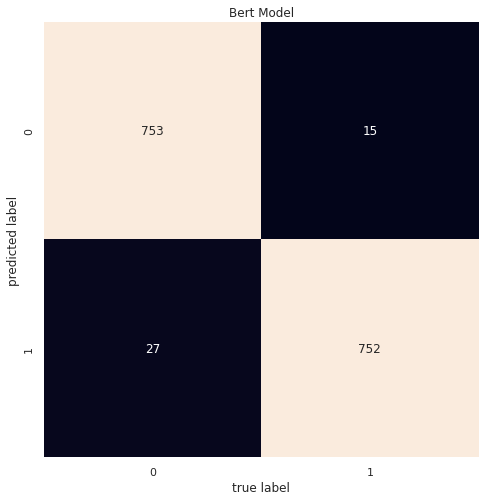

In [13]:
bert = BERTClassifier()
bert.fit(X_train_encoded, y_train_encoded, epochs = 10, validation_split=0.3)
yhats = bert.predict(X_test_encoded)
mat = confusion_matrix(y_test, yhats)
sns.set(rc = {'figure.figsize':(8,8)})
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
              xticklabels=['%d' %i for i in range(2)],
              yticklabels=['%d' %i for i in range(2)])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Bert Model')
  
print(classification_report(y_test, yhats,
                              target_names=['%d' %i for i in range(2)]))

It is done! The results already look great even with 10 epochs. However, since this is a some sort of sentiment detection model, our priority should be minimizing the false negatives. To do this, we might sacrifice a tiny bit of accuracy. We will simply lower the threshold in the code block below and see how our model performs... We will set the threshold to 2 and see recall values.

Well, it looks like we found the sweet spot. We not only reduced the recall, but also kept the precision and accuracy high!

Now let's add some sample sentences to see how the model performs in real world scenarios

In [14]:
sample = [
    "i wanna die so bad that i might kill myself tomorrow",
    "i love it when it snows",
    "i went to a fast food today and ate burgers",
    "today was the day where i almost ended it all i have been thinking of comitting suicide for months",
    "life is so bad man i dont know i feel terrible",
    "i m feeling tired today",
    "i am so done bro",
    "i want to go to sleep and wake up early tomorrow",
    "i am so stressed about my exam tomorrow i need help so badly depressed",
    "i am feeling so lonely",
    ]
sample_encoded = np.array(bert_encoder(sample))
print(bert.predict(sample_encoded, threshold = 0.3))

1/1 [==============================] - 0s 17ms/step
[1, 0, 0, 1, 1, 0, 1, 0, 1, 1]


In [15]:
#@title 2 - LSTM Model
class LSTMClassifier(BaseLearningAlgorithm):
  def __init__(self):
    self.vocab_size = 20000
    self.embedding_dim = 1024
    self.tokenizer = Tokenizer(num_words = 20000)
    self.model = Sequential([
        Embedding(self.vocab_size, self.embedding_dim, input_length = 1024),
        Bidirectional(LSTM(1024)),
        Dense(2048, activation='relu'),
        Dropout(0.2),
        Dense(2048, activation='relu'),
        Dense(1024, activation='relu'),
        Dropout(0.2),
        Dense(512, activation='relu'),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    self.model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate= 0.00001), metrics = ["accuracy"])

  def fit(self, X_train:np.array, y_train: np.array , epochs, validation_split):
    self.tokenizer.fit_on_texts(X_train)
    X_train_sequences = self.tokenizer.texts_to_sequences(X_train)
    X_train_tokenized = pad_sequences(X_train_sequences,truncating="post",padding="post", maxlen=1024, dtype='float32')
    self.model.fit(X_train_tokenized, y_train, validation_split= validation_split, epochs=epochs, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode="min")])

  def predict(self, X_test, threshold) -> np.array:
    self.tokenizer.fit_on_texts(X_test)
    X_test_sequences = self.tokenizer.texts_to_sequences(X_test)
    X_test_tokenized = pad_sequences(X_test_sequences,truncating="post",padding="post", maxlen=1024, dtype='float32') 
    predictions = self.model.predict(X_test_tokenized)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(predictions)
    normalized_predictions = scaler.transform(predictions)
    binary_predictions = [1 if prediction > threshold else 0 for prediction in normalized_predictions ]
    return [normalized_predictions, binary_predictions]

  
  def summary(self):
    self.model.summary()


  @property 
  def name(self) -> str:
    """Returns the name of the algorithm."""
    return "LSTM model"


Let's instantiate our class, train and evaluate it...

In [ ]:
lstm = LSTMClassifier()
lstm.fit(X_train, y_train, epochs = 100, validation_split=0.2)
yhats = lstm.predict(X_test, threshold = 0.5)
mat = confusion_matrix(y_test, yhats)
sns.set(rc = {'figure.figsize':(8,8)})
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
              xticklabels=['%d' %i for i in range(2)],
              yticklabels=['%d' %i for i in range(2)])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Bert Model')
  
print(classification_report(y_test, yhats,
                              target_names=['%d' %i for i in range(2)]))

Epoch 1/100
155/155 [==============================] - 35s 187ms/step - loss: 0.5713 - accuracy: 0.7109 - val_loss: 0.3325 - val_accuracy: 0.8860
Epoch 2/100
 75/155 [=============>................] - ETA: 13s - loss: 0.3477 - accuracy: 0.8667

In [ ]:
yhats = lstm.predict(X_test, threshold = 0.1)
print(classification_report(y_test, yhats[1]))
confusion_matrix(y_test,yhats[1]) #yhats[1] returns binary predictions we made (0 or 1) 

As it can be seen, the LSTM model doesn't perform as good as our BERT model.While changing the classification threshold helps a bit, it is still not as good as BERT.

Now, let's save the trained models using pickle module to use at a later time or deploy!

In [ ]:
pickle.dump(bert, open("bert.pickle", "wb"))
pickle.dump(lstm, open("lstm.pickle", "wb"))

In [ ]:
pickle.dump(bert, open("bert", "wb"))


DONE!